# Apply CNN Classifier to DESI Spectra and visualize results with gradCAM

Mini-SV2 tiles from February-March 2020:
- https://desi.lbl.gov/trac/wiki/TargetSelectionWG/miniSV2

See also the DESI tile picker with (limited) SV0 tiles from March 2020:
- https://desi.lbl.gov/svn/data/tiles/trunk/
- https://desi.lbl.gov/svn/data/tiles/trunk/SV0.html

In [1]:
import sys
sys.path.append('/global/homes/p/palmese/desi/timedomain/desitrip/py/')

from desispec.io import read_spectra, write_spectra
from desispec.spectra import Spectra
from desitarget.cmx.cmx_targetmask import cmx_mask

from desitrip.preproc import rebin_flux, rescale_flux

from astropy.io import fits
from astropy.table import Table, vstack, hstack

from glob import glob
from datetime import date

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow import keras

In [2]:
mpl.rc('font', size=14)

In [3]:
# Set up BGS target bit selection.
cmx_bgs_bits = '|'.join([_ for _ in cmx_mask.names() if 'BGS' in _])

## Select a Date & Tile from the Tile Picker

In [4]:
# Choose tile 66000 from Mar 14, 2020
tile_id = 66003
obsdate = 20200315

# Access redux folder.
redux='/global/project/projectdirs/desi/spectro/redux/daily/tiles'
prefix_in='/'.join([redux, '{:05d}/{}'.format(tile_id, obsdate)])
if not os.path.isdir(prefix_in):
    print('{} does not exist.'.format(prefix_in))

In [5]:
# List zbest and coadd files.
# Data are stored by petal ID.
zbfiles = sorted(glob('{}/zbest*.fits'.format(prefix_in)))
cafiles = sorted(glob('{}/coadd*.fits'.format(prefix_in)))

In [6]:
# zbest files from redrock.
zbfiles

['/global/project/projectdirs/desi/spectro/redux/daily/tiles/66003/20200315/zbest-0-66003-20200315.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/66003/20200315/zbest-1-66003-20200315.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/66003/20200315/zbest-2-66003-20200315.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/66003/20200315/zbest-3-66003-20200315.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/66003/20200315/zbest-4-66003-20200315.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/66003/20200315/zbest-5-66003-20200315.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/66003/20200315/zbest-6-66003-20200315.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/66003/20200315/zbest-7-66003-20200315.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/66003/20200315/zbest-8-66003-20200315.fits',
 '/global/project/projectdirs/desi/spectro/red

In [7]:
# Co-added spectra from multiple exposures + the three spectrograph arms.
cafiles

['/global/project/projectdirs/desi/spectro/redux/daily/tiles/66003/20200315/coadd-0-66003-20200315.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/66003/20200315/coadd-1-66003-20200315.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/66003/20200315/coadd-2-66003-20200315.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/66003/20200315/coadd-3-66003-20200315.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/66003/20200315/coadd-4-66003-20200315.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/66003/20200315/coadd-5-66003-20200315.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/66003/20200315/coadd-6-66003-20200315.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/66003/20200315/coadd-7-66003-20200315.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/66003/20200315/coadd-8-66003-20200315.fits',
 '/global/project/projectdirs/desi/spectro/red

## Load the Keras Model

Load a model trained on real or simulated data using the native Keras output format. In the future this could be updated to just load the Keras weights.

In [8]:
tfmodel = '/global/homes/l/lehsani/timedomain/desitrip/docs/nb/models_9label_first/6_b65_e200_9label/b65_e200_9label_model'
#tfmodel = '/global/homes/s/sybenzvi/desi/timedomain/desitrip/docs/nb/6label_cnn_restframe'
if os.path.exists(tfmodel):
    classifier = keras.models.load_model(tfmodel)
else:
    classifier = None
    print('Sorry, could not find {}'.format(tfmodel))

In [9]:
if classifier is not None:
    classifier.summary()

Model: "SNnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Spec (InputLayer)      [(None, 150, 1)]          0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 150, 8)            48        
_________________________________________________________________
batch_normalization_20 (Batc (None, 150, 8)            32        
_________________________________________________________________
activation_20 (Activation)   (None, 150, 8)            0         
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 75, 8)             0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 75, 16)            656       
_________________________________________________________________
batch_normalization_21 (Batc (None, 75, 16)            64    

## Loop Through Spectra and Classify

In [10]:
# Loop through zbest and coadd files for each petal.
# Extract the fibermaps, ZBEST tables, and spectra.
# Keep only BGS targets passing basic event selection.
allzbest = None
allfmap = None
allwave = None
allflux = None
allivar = None
allmask = None
allres  = None

In [11]:
for cafile, zbfile in zip(cafiles, zbfiles):
    # Access data per petal.
    zbest = Table.read(zbfile, 'ZBEST')
    fibermap = Table.read(zbfile, 'FIBERMAP')
    pspectra = read_spectra(cafile)

    # Apply standard event selection.
    isTGT = fibermap['OBJTYPE'] == 'TGT'
    isGAL = zbest['SPECTYPE'] == 'GALAXY'
    isBGS = fibermap['CMX_TARGET'] & cmx_mask.mask(cmx_bgs_bits) != 0
    select = isTGT & isGAL & isBGS

    # Accumulate spectrum data.
    if allzbest is None:
        allzbest = zbest[select]
        allfmap = fibermap[select]
        allwave = pspectra.wave['brz']
        allflux = pspectra.flux['brz'][select]
        allivar = pspectra.ivar['brz'][select]
        allmask = pspectra.mask['brz'][select]
        allres  = pspectra.resolution_data['brz'][select]
    else:
        allzbest = vstack([allzbest, zbest[select]])
        allfmap = vstack([allfmap, fibermap[select]])
        allflux = np.vstack([allflux, pspectra.flux['brz'][select]])
        allivar = np.vstack([allivar, pspectra.ivar['brz'][select]])
        allmask = np.vstack([allmask, pspectra.mask['brz'][select]])
        allres  = np.vstack([allres, pspectra.resolution_data['brz'][select]])

In [12]:
# Apply the DESITRIP preprocessing to selected spectra.
rewave, reflux, reivar = rebin_flux(allwave, allflux, allivar, allzbest['Z'],
                                    minwave=2500., maxwave=9500., nbins=150,
                                    log=True, clip=True)
rsflux = rescale_flux(reflux)

In [13]:
# Run the classifier on the spectra.
# The output layer uses softmax activation to produce an array of label probabilities.
# The classification is based on argmax(pred).
pred = classifier.predict(rsflux)

In [14]:
pred.shape

(2598, 9)

In [15]:
ymax = np.max(pred, axis=1)

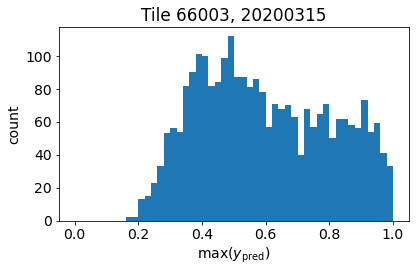

In [16]:
fig, ax = plt.subplots(1,1, figsize=(6,4), tight_layout=True)
ax.hist(ymax, bins=np.linspace(0,1,51))
ax.set(xlabel='$\max{(y_\mathrm{pred})}$',
       ylabel='count',
       title='Tile {}, {}'.format(tile_id, obsdate));

### Selection on Classifier Output

To be conservative we can select only spectra where the classifier is very confident in its output, e.g., ymax > 0.99. See the [CNN training notebook](https://github.com/desihub/timedomain/blob/master/desitrip/docs/nb/cnn_multilabel-restframe.ipynb) for the motivation behind this cut.

In [29]:
idx = np.argwhere(ymax > 0.99)
labels = np.argmax(pred, axis=1)

In [30]:
idx.shape
label_names = ['Galaxy',
          'SN Ia',
          'SN Ib',
          'SN Ib/c',
          'SN Ic',
          'SN IIn',
          'SN IIL/P',
          'SN IIP',
          'KN']

In [31]:
# Randomly select 16 of the spectra and plot them.
#selection = sorted(np.random.choice(idx.flatten(), size=idx.shape[0], replace=False))
selection=idx

### GradCAM action happens here

Adapting from https://keras.io/examples/vision/grad_cam/

In [43]:
import tensorflow as tf
last_conv_layer_name = "conv1d_23"
classifier_layer_names = [
"batch_normalization_23",
"activation_23",
"max_pooling1d_23",
"flatten_5",
"dense_5",
"dropout_5",
"Output_Classes"
]

In [101]:
def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        print(layer_name,x.shape)
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    #for i in range(pooled_grads.shape[-1]):
    #    last_conv_layer_output[:, :, i] *= pooled_grads[i]

    last_conv_layer_output *= pooled_grads
    print(last_conv_layer_output.shape)
    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)
    #Following has To be changed
    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    #print(heatmap,np.max(heatmap))
    #heatmap = heatmap / np.max(heatmap)
    return heatmap

Predicted: [[0.09923146 0.34833482 0.1202185  0.0136816  0.04600524 0.00665843
  0.01165331 0.01139775 0.3428189 ]]
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Input_Spec:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Input_Spec:0
batch_normalization_23 (None, 18, 64)
activation_23 (None, 18, 64)
max_pooling1d_23 (None, 18, 64)
flatten_5 (None, 9, 64)
dense_5 (None, 576)
dropout_5 (None, 256)
Output_Classes (None, 256)
(18, 64)


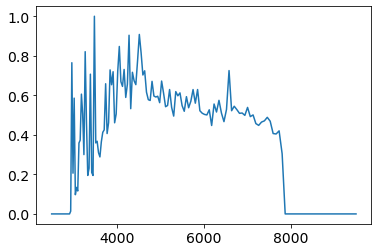

In [105]:
import matplotlib.cm as cm
# Prepare image
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions
myarr=rsflux[:1,:] 

# Print what the top predicted class is
preds = classifier.predict(myarr)
print("Predicted:", preds)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    myarr, classifier, last_conv_layer_name, classifier_layer_names
)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
#jet_colors = jet(np.arange(heatmap.min(),heatmap.max()))
#jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
#jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = heatmap.resize((myarr.shape[1]))

plt.plot(rewave, myarr[0,:],c=jet_heatmap)


### Plot input spectra of objects classified as transients
Plot rest frame spectra

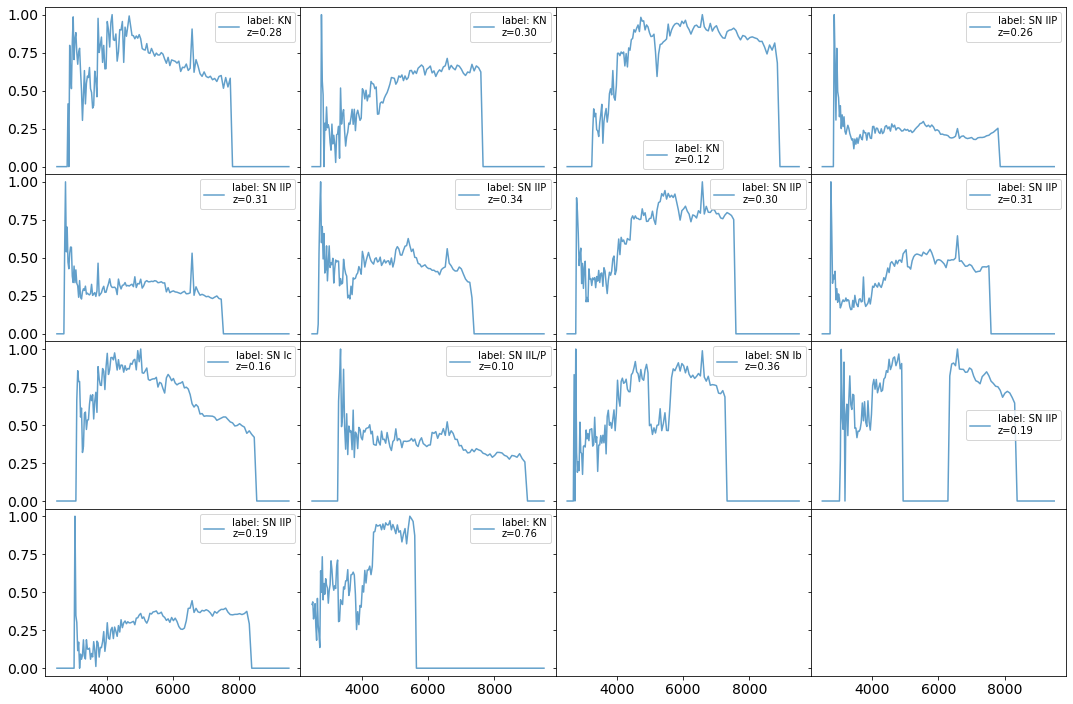

In [22]:
fig, axes = plt.subplots(4,4, figsize=(15,10), sharex=True, sharey=True,
                         gridspec_kw={'wspace':0, 'hspace':0})

for j, ax in zip(selection, axes.flatten()):
    ax.plot(rewave, rsflux[j[0]], alpha=0.7, label='label: '+label_names[labels[j[0]]]+'\nz={:.2f}'.format(allzbest[j[0]]['Z']))
    ax.legend(fontsize=10)

# for k in [0,1,2]:
#     axes[k,0].set(ylabel=r'flux [erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$]')
#     axes[2,k].set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]',
#                   xlim=(3500,9900))
fig.tight_layout();

### Plot input spectra of objects classified as transients
Plot observed spectra

In [23]:
testwave, testflux, testivar = rebin_flux(allwave, allflux, allivar,
                                    minwave=2500., maxwave=9500., nbins=150,
                                    log=True, clip=True)

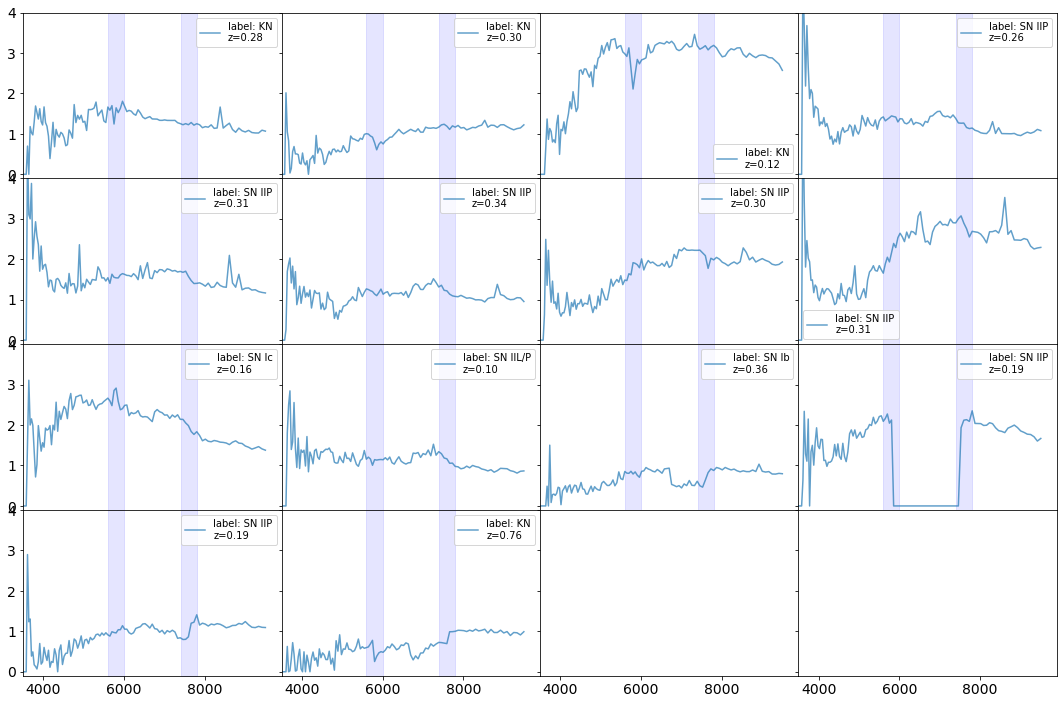

In [25]:
fig, axes = plt.subplots(4,4, figsize=(15,10), sharex=True, sharey=True,
                         gridspec_kw={'wspace':0, 'hspace':0})

for j, ax in zip(selection, axes.flatten()):
    ax.plot(testwave, testflux[j[0]], alpha=0.7, label='label: '+label_names[labels[j[0]]]+'\nz={:.2f}'.format(allzbest[j[0]]['Z']))
    ax.set(xlim=(3500,9900),ylim=(-0.1,4))
    ax.fill_between([5600,6000],[-0.1,-0.1],[4,4],alpha=0.1,color='blue')
    ax.fill_between([7400,7800],[-0.1,-0.1],[4,4],alpha=0.1,color='blue')
    ax.legend(fontsize=10)

# for k in [0,1,2]:
#     axes[k,0].set(ylabel=r'flux [erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$]')
#     axes[2,k].set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]',
#                   xlim=(3500,9900))
fig.tight_layout();